# Bajar-Microdatos.ipynb
El objetivo de esta notebook es presentar código que permite sistematizar la descarga de datos de todos los trimestres de 2016 en adelante de la Encuesta Permanente de Hogares, dando o cómo resultado un archivo en formato .csv para los datos correspondientes a los hogares y otro igual para los datos correspondientes a individuos. Por último, se presenta un breve análisis como un pequeño ejemplo de un análisis posible con estos datos.
La fuente de los datos se puede encontrar en [este](https://www.indec.gob.ar/indec/web/Institucional-Indec-BasesDeDatos) sitio web.

In [1]:
import os
import time
import zipfile
import shutil
import re
from tqdm import tqdm
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### En esta parte se crean las etiquetas para cada trimestre y las URL para descargar los datos
Las etiquetas deberían estar en formato "yy-QT" (por ejemplo, 17-3T es el tercer trimestre de de 2017). En la celda siguiente la variable last_quarter define cuál es el último trimestre que se va a descargar. Esta variable es un string que debería tener el mismo formato que las demás etiquetas.    
En la segunda celda de esta sección se crean las URL que se utilizan para descargar los datos, teniendo en cuenta que en 2016 y en el primer trimestre de 2017 las URL son diferentes.   
Por último, se crea un diccionario donde cada llave es la etiqueta de un trimestre y su correspondiente valor es la URL para descargar los datos de ese mismo trimestre.

In [2]:
# This cell creates the key for each quarter

# The first year and quarter
year = 2016
quarter = 2

last_quarter = '24-1T' # This should be the last quarter to download

key_list = []
while True:
    year_str = str(year)[-2:]
    key_str = f'{year_str}-{quarter}T'
    key_list.append(key_str)
    if key_str == last_quarter:
        break
    quarter += 1
    if quarter == 5:
        quarter = 1
        year += 1

key_list

['16-2T',
 '16-3T',
 '16-4T',
 '17-1T',
 '17-2T',
 '17-3T',
 '17-4T',
 '18-1T',
 '18-2T',
 '18-3T',
 '18-4T',
 '19-1T',
 '19-2T',
 '19-3T',
 '19-4T',
 '20-1T',
 '20-2T',
 '20-3T',
 '20-4T',
 '21-1T',
 '21-2T',
 '21-3T',
 '21-4T',
 '22-1T',
 '22-2T',
 '22-3T',
 '22-4T',
 '23-1T',
 '23-2T',
 '23-3T',
 '23-4T',
 '24-1T']

In [3]:
# This chunk of code creates the URLs
value_list = []
for key in key_list:
    quarter = key[-2]
    year = '20' + key[:2]
    
    # Dealing with URLs for 2016
    if (year == '2016'):
        if quarter == '2':
            ordinal_str = 'do'            
        if quarter == '3':
            ordinal_str = 'er'
        if quarter == '4':
            ordinal_str = 'to'
        url_1 = 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/'
        url_2 = f'EPH_usu_{quarter}{ordinal_str}Trim_{year}_txt.zip'
        value_list.append(url_1 + url_2)
        continue

    # Dealing with the 2017-1T case
    if key == '17-1T':
        url_1 = 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/'
        url_2 = 'EPH_usu_1er_Trim_2017_txt.zip'
        value_list.append(url_1 + url_2)
        continue

    # The rest should work with this
    else:
        url_1 = 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/'
        url_2 = f'eph/EPH_usu_{quarter}_Trim_{year}_txt.zip'
        value_list.append(url_1 + url_2)

value_list

['https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_2doTrim_2016_txt.zip',
 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_3erTrim_2016_txt.zip',
 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_4toTrim_2016_txt.zip',
 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_1er_Trim_2017_txt.zip',
 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_2_Trim_2017_txt.zip',
 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_3_Trim_2017_txt.zip',
 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_4_Trim_2017_txt.zip',
 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_1_Trim_2018_txt.zip',
 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_2_Trim_2018_txt.zip',
 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_3_Trim_2018_txt.zip',
 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_4_Trim_2018_txt.zip',
 'https://www.indec.gob.ar/ftp/cuadros/menusuperi

In [4]:
# This creates the dictonary to download the data
url_dict = dict(zip(key_list, value_list))
url_dict

{'16-2T': 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_2doTrim_2016_txt.zip',
 '16-3T': 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_3erTrim_2016_txt.zip',
 '16-4T': 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_4toTrim_2016_txt.zip',
 '17-1T': 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_1er_Trim_2017_txt.zip',
 '17-2T': 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_2_Trim_2017_txt.zip',
 '17-3T': 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_3_Trim_2017_txt.zip',
 '17-4T': 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_4_Trim_2017_txt.zip',
 '18-1T': 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_1_Trim_2018_txt.zip',
 '18-2T': 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_2_Trim_2018_txt.zip',
 '18-3T': 'https://www.indec.gob.ar/ftp/cuadros/menusuperior/eph/EPH_usu_3_Trim_2018_txt.zip',
 '18-4T': 'https://www.indec.gob.ar/ftp/cuadr

## Descargando y Extrayendo los Datos
En esta sección se descargan los datos de la web del INDEC. Como los datos (en formato de archivos .txt) se encuentran dentro de archivos .zip, los mismos se extraen y se separan en los correspondientes a los datos de hogares e individuos.    
Primero se crea una carpeta llamada "datos" en el mismo directorio donde se ubica esta notebook, dentro de esa carpeta se crea otra, denominada "zip", donde se descargan los archivos del INDEC, todos con la etiqueta del trimestre que corresponde (por ejemplo, 18-2T.zip) y se revisa que los archivos descargados sean válidos.    
Luego se crean las carpetas "individual" y "hogar" dentro de "datos" y se extraen los archivos a sus respectivas carpetas, también con las etiquetas de trimestres (por ejemplo, 20-3T-individual.txt o 22-1T-hogar.txt). Se revisa tambén que los archivos de todos los trimestres estén en las dos carpetas.   
Al final se elimina la carpeta "zip" con los archivos descargados y se dejan las carpetas que contienen los datos de la EPH.

In [5]:
# Create the "datos" folder if it doesn't exist
if 'datos' not in os.listdir():
    os.makedirs('datos')
    os.makedirs('datos/zip')

# Download the files
for key in tqdm(url_dict, desc='Downloading files'):
    url = url_dict[key]
    response = requests.get(url, stream=True)
    
    # If the website responds 
    if response.status_code == 200:
        with open(f'datos/zip/{key}.zip', 'wb') as f:
            f.write(response.content)

        # Try to avoid DDoS detection
        time.sleep(1)

    else:
        print(f'Failed to download {key}')

In [6]:
# Checking the files
error_files = 0
zip_dir = 'datos/zip'

for file in os.listdir(zip_dir):
    zip_path = os.path.join(zip_dir, file)
    try:
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.testzip()
    except zipfile.BadZipFile:
        error_files += 1
        print(f'{file} is not a valid zip file')

if error_files == 0:
    print('It looks like all the zip files are valid')
else:
    print(f'Found {error_files} invalid zip file(s)')

It looks like all the zip files are valid


In [7]:
# Create the folders inside the "datos" folder
if 'individual' not in os.listdir('datos'):
    os.mkdir('datos/individual')
if 'hogar' not in os.listdir('datos'):
    os.mkdir('datos/hogar')

In [8]:
def extract_rename_and_move(key):
    """This function extracts the .txt files from the .zip file, renames them 
    and moves them to the correct folders (datos/individual and datos/hogar). To
    simplify the code a bit it creates a folder called extracted, which it uses 
    to store the extracted files, and it deletes the folder at the end 
    Args:
        key (str): the key corresponding to the quarter. Its format should be
        yy-QT, so that, for example, 23-2T is the second quarter of 2023.
    """    
    # Creating the "extracted" directory
    extr_dir = 'datos/extracted'
    if not os.path.exists(extr_dir):
        os.makedirs(extr_dir)
    
    zip_dir = f'datos/zip/{key}.zip'
    
    # Extracting the files without the folders
    with zipfile.ZipFile(zip_dir, 'r') as z:
        for i in z.namelist():
            filename = os.path.basename(i)
            # Skip directories
            if not filename:
                continue
            
            source = z.open(i)
            target_path = os.path.join(extr_dir, filename)
            with open(target_path, "wb") as target:
                shutil.copyfileobj(source, target)
            source.close()
    
    # Regex patterns to try to avoid problems with filenames
    hogar_re = r'[hH][oO][gG][aA][rR]'
    individual_re = r'[iI][nN][dD][iI][vV][iI][dD][uU][aA][lL]'
    
    # Looping over the recently extracted files
    for filename in os.listdir(extr_dir):
        old_path = os.path.join(extr_dir, filename)
        
        # Finding the "hogar" data
        if re.search(hogar_re, filename) and filename.endswith('.txt'):
            new_filename = f'{key}-hogar.txt'
            new_path = os.path.join('datos', 'hogar', new_filename)
            os.rename(old_path, new_path)
        
        # Finding the "individual" data
        elif ((re.search(individual_re, filename) or 'personas' in filename) and 
              filename.endswith('.txt')):
            new_filename = f'{key}-individual.txt'
            new_path = os.path.join('datos', 'individual', new_filename)
            os.rename(old_path, new_path)
    
    # Deleting the "extracted" folder with all of its contents
    shutil.rmtree(extr_dir)

In [9]:
# Extracting, renaming and moving the data. Also deletes the zip folder
for key in key_list:
    extract_rename_and_move(key)
shutil.rmtree('datos/zip')

In [10]:
# Checking if all the files for the individual dataset are there
equal_counter = 0
for file in os.listdir('datos/individual'):
    for key in key_list:
        if file[:5] == key:
            equal_counter += 1
            continue

if equal_counter == len(key_list):
    print('All the files for the individual dataset are available.')
else:
    print(f'There are {len(key_list) - equal_counter} missing files')

# Checking if all the files for the hogar dataset are there
equal_counter = 0
for file in os.listdir('datos/hogar'):
    for key in key_list:
        if file[:5] == key:
            equal_counter += 1
            continue

if equal_counter == len(key_list):
    print('All the files for the hogar dataset are available.')
else:
    print(f'There are {len(key_list) - equal_counter} missing files')

All the files for the individual dataset are available.
All the files for the hogar dataset are available.


## Leyendo los datos a una tabla
En esta sección se leen los archivos para crear una tabla para los datos de hogares y otra para los datos de individuos.
Dado que la cantidad de datos puede causar que las computadoras se queden sin memoria (sobre todo si la PC tiene 8gb de RAM o menos) se recomienda usar las variables hogar_cols_to_keep y ind_cols_to_keep para listar las variables que se necesitan en los datasets de hogares e individuos, respectivamente, y eliminar las restantes.   
Los nombres de las variables se pueden conseguir en el diseño de registro de la EPH, aunque en algunos casos los nombres de las variables pueden tener pequeños errores (por ejemplo, en el registro existe una variable llamada "IX_Tot", pero su nombre en los archivos es "IX_TOT").
Al final de esta sección se guardan los archivos hogar.csv e individuos.csv en la carpeta "datos", ambos conteniendo los datos de sus respectivos datasets.   
En este caso, a modo de ejemplo, se eligen las variables "CODUSU", "NRO_HOGAR", "IX_TOT", "DECIFR" y"DECCFR" en el dataset de hogares y "CODUSU", "NRO_HOGAR" y "DECINDR" en dataset de individuos. El movtivo por el cual se eligen estas variables de detalla en la próxima sección.

In [11]:
def read_data(key, hogar_or_individual, cols_to_keep=None):
    """This function reads a txt file as formatted by INDEC and returns a pandas
    DataFrame with the data and a few small optimizations to save memory. It is
    recommended to use cols_to_keep to reduce memory footprint.
    Args:
        key (str): the key corresponding to the quarter. It's format should be
        yy-QT, so that, for example, 23-2T is the second quarter of 2023.
        hogar_or_individual (str): should be either "hogar" or "individual".
        cols_to_keep (list, optional): a list of columns to keep, and the rest
        are discarded. If None, all the columns are kept. Defaults to None.

    Returns:
        pandas.DataFrame: a DataFrame containing the data from the .txt file.
    """    
    # Stopping the user from removing the quarter and year column
    if cols_to_keep is not None:
        if ('ANO4' not in cols_to_keep) and ('TRIMESTRE' not in cols_to_keep):
            cols_to_keep.append('TRIMESTRE')
            cols_to_keep.append('ANO4')
    
    # Reading the data
    df = pd.read_csv(f'datos/{hogar_or_individual}/{key}-' +
                     f'{hogar_or_individual}.txt', sep=';',
                     low_memory=False, usecols=cols_to_keep)
    
    # Converting int64 to int16 to save memory
    d = dict.fromkeys(df.select_dtypes('int').columns, 'int16')
    df = df.astype(d).copy()

    # Converting fp64 to fp16 to save memory
    d = dict.fromkeys(df.select_dtypes('float').columns, 'float16')
    df = df.astype(d).copy()


    # Converting the date data to quarters
    date_df = df[['ANO4', 'TRIMESTRE']].astype(str).copy()
    quarter = pd.to_datetime(date_df['ANO4'] + 'Q' + date_df['TRIMESTRE'])
    quarter = quarter.dt.to_period('Q')
    df['quarter'] = quarter.copy()
    df = df.drop(columns=['ANO4', 'TRIMESTRE'])

    return df

In [12]:
# This controls which columns are kept
hogar_cols_to_keep = ['CODUSU', 'NRO_HOGAR', 'IX_TOT', 'DECIFR', 'DECCFR']

hogar = read_data(key_list[0], 'hogar', hogar_cols_to_keep)
for key in key_list[1:]:
    new_hogar = read_data(key, 'hogar', hogar_cols_to_keep)
    hogar = pd.concat((hogar, new_hogar))
    del(new_hogar)

hogar

,CODUSU,NRO_HOGAR,IX_TOT,DECIFR,DECCFR,quarter
0,TQRMNOQUXHKOKMCDEGKDB00475140,1,4,12,12,2016Q2
1,TQRMNOQQYHMMKTCDEGKDB00475009,1,3,07,06,2016Q2
2,TQRMNORVUHJMKSCDEGKDB00475326,1,2,05,07,2016Q2
3,TQRMNOPQUHMMKTCDEGKDB00475005,1,2,08,09,2016Q2
4,TQRMNORVRHJMKSCDEGKDB00475324,1,2,02,03,2016Q2
...,...,...,...,...,...,...
16099,TQRMNOPXXHLKKUCDEFNFF00852324,1,3,12,12,2024Q1
16100,TQRMNOPQTHKMLMCDEHMHF00861771,1,2,2,3,2024Q1
16101,TQRMNOSYXHMMLNCDEFNFF00798999,1,6,2,1,2024Q1
16102,TQRMNOPTSHLOLQCDEFNFF00852331,1,1,2,6,2024Q1


In [13]:
# This controls which columns are kept
ind_cols_to_keep = ['CODUSU', 'NRO_HOGAR', 'DECINDR']

individual = read_data(key_list[0], 'individual', ind_cols_to_keep)
for key in key_list[1:]:
    new_individual = read_data(key, 'individual', ind_cols_to_keep)
    individual = pd.concat((individual, new_individual))
    del(new_individual)

individual

,CODUSU,NRO_HOGAR,DECINDR,quarter
0,TQRMNOQTUHMMTQCDEIJAH00483381,1,10,2016Q2
1,TQRMNOQTUHMMTQCDEIJAH00483381,1,9,2016Q2
2,TQRMNOQTUHMMTQCDEIJAH00483381,1,0,2016Q2
3,TQRMNOPSRHLOLRCDEIJAH00483068,1,10,2016Q2
4,TQRMNORUVHLNMNCDEIJAH00484887,1,0,2016Q2
...,...,...,...,...
46045,TQRMNOPUQHKMKNCDEIJAH00861661,1,12,2024Q1
46046,TQRMNOPUQHKMKNCDEIJAH00861661,1,13,2024Q1
46047,TQRMNOPUQHKMKNCDEIJAH00861661,1,13,2024Q1
46048,TQRMNOPUQHKMKNCDEIJAH00861661,1,13,2024Q1


In [14]:
# Saving both datasets to CSV files
hogar.to_csv('datos/hogar.csv')
individual.to_csv('datos/datos_individuales.csv')

## Ejemplo de Análisis de Datos
En el caso de esta notebook se propone como ejemplo un breve análisis de la relación entre cantidad de personas en los hogares y los ingresos totales y per cápita de los mismos a través de sus respectivos deciles.   
Además se quiere analizar la relacíon entre cantidad de personas en un hogar y los ingresos de las personas que viven en esos hogares, también analizando a qué decil de ingresos pertenecen esas personas.    
En las siguientes dos celdas se arregla el formato de las columnas de deciles de ingresos para el dataset de hogares. Luego se crean grupos de cantidades de personas en los hogares (1 o 2 personas, 3 o 4, de 5 a 8 personas, de 9 a 12 y 13 o más) y grupos de deciles (deciles 1 a 3, deciles 4 a 7 y deciles 8 a 10) para luego calcular qué porcentaje de hogares se encuentra en cada decil según la cantidad de personas que viven en los mismos, y luego se realiza un gráfico de barras agrupadas para los ingresos totales y per cápita.
Finalmente, se utiliza un procedimiento muy parecido para analizar en qué deciles de ingresos se encuentran las personas con ingresos según la cantidad de personas que viven en un hogar.

In [15]:
# Small function to fix a few strings inside the columns
def remove_first_zeros(x):
    if type(x) is str:
        x = re.sub('0[1-9]', x[1], x)
    return x

# Fixing a few strings
hogar['DECIFR'] = hogar['DECIFR'].apply(remove_first_zeros)

# Removing any NaNs
hogar['DECIFR'] = hogar['DECIFR'].fillna(0)

# Removing any invalid data
bool_mask = ((hogar['DECIFR'] == 12) | (hogar['DECIFR'] == '12') |
             (hogar['DECIFR'] == 13) | (hogar['DECIFR'] == '13') |
             (hogar['DECIFR'] == '00') | (hogar['DECIFR'] == '  '))
hogar.loc[bool_mask, 'DECIFR'] = 0

hogar['DECIFR'] = hogar['DECIFR'].astype('int16')
display(hogar.dtypes)
hogar

CODUSU              object
NRO_HOGAR            int16
IX_TOT               int16
DECIFR               int16
DECCFR              object
quarter      period[Q-DEC]
dtype: object

,CODUSU,NRO_HOGAR,IX_TOT,DECIFR,DECCFR,quarter
0,TQRMNOQUXHKOKMCDEGKDB00475140,1,4,0,12,2016Q2
1,TQRMNOQQYHMMKTCDEGKDB00475009,1,3,7,06,2016Q2
2,TQRMNORVUHJMKSCDEGKDB00475326,1,2,5,07,2016Q2
3,TQRMNOPQUHMMKTCDEGKDB00475005,1,2,8,09,2016Q2
4,TQRMNORVRHJMKSCDEGKDB00475324,1,2,2,03,2016Q2
...,...,...,...,...,...,...
16099,TQRMNOPXXHLKKUCDEFNFF00852324,1,3,0,12,2024Q1
16100,TQRMNOPQTHKMLMCDEHMHF00861771,1,2,2,3,2024Q1
16101,TQRMNOSYXHMMLNCDEFNFF00798999,1,6,2,1,2024Q1
16102,TQRMNOPTSHLOLQCDEFNFF00852331,1,1,2,6,2024Q1


In [16]:
# Fixing a few strings
hogar['DECCFR'] = hogar['DECCFR'].apply(remove_first_zeros)

# Removing any NaNs
hogar['DECCFR'] = hogar['DECCFR'].fillna(0)

# Removing any invalid data
bool_mask = ((hogar['DECCFR'] == 12) | (hogar['DECCFR'] == '12') |
             (hogar['DECCFR'] == 13) | (hogar['DECCFR'] == '13') |
             (hogar['DECCFR'] == '00') | (hogar['DECCFR'] == '  '))
hogar.loc[bool_mask, 'DECCFR'] = 0

hogar['DECCFR'] = hogar['DECCFR'].astype('int16')
display(hogar.dtypes)
hogar

CODUSU              object
NRO_HOGAR            int16
IX_TOT               int16
DECIFR               int16
DECCFR               int16
quarter      period[Q-DEC]
dtype: object

,CODUSU,NRO_HOGAR,IX_TOT,DECIFR,DECCFR,quarter
0,TQRMNOQUXHKOKMCDEGKDB00475140,1,4,0,0,2016Q2
1,TQRMNOQQYHMMKTCDEGKDB00475009,1,3,7,6,2016Q2
2,TQRMNORVUHJMKSCDEGKDB00475326,1,2,5,7,2016Q2
3,TQRMNOPQUHMMKTCDEGKDB00475005,1,2,8,9,2016Q2
4,TQRMNORVRHJMKSCDEGKDB00475324,1,2,2,3,2016Q2
...,...,...,...,...,...,...
16099,TQRMNOPXXHLKKUCDEFNFF00852324,1,3,0,0,2024Q1
16100,TQRMNOPQTHKMLMCDEHMHF00861771,1,2,2,3,2024Q1
16101,TQRMNOSYXHMMLNCDEFNFF00798999,1,6,2,1,2024Q1
16102,TQRMNOPTSHLOLQCDEFNFF00852331,1,1,2,6,2024Q1


In [17]:
people_groups = ((0, 2), (2, 4), (4, 8), (8, 12), (12, 22))
hogar['people_group'] = ''
for tupl in people_groups:
    bool_mask = (hogar['IX_TOT'] > tupl[0]) & (hogar['IX_TOT'] <= tupl[1])
    hogar.loc[bool_mask, 'people_group'] = f'{tupl[0]+1}-{tupl[1]}'

hogar

,CODUSU,NRO_HOGAR,IX_TOT,DECIFR,DECCFR,quarter,people_group
0,TQRMNOQUXHKOKMCDEGKDB00475140,1,4,0,0,2016Q2,3-4
1,TQRMNOQQYHMMKTCDEGKDB00475009,1,3,7,6,2016Q2,3-4
2,TQRMNORVUHJMKSCDEGKDB00475326,1,2,5,7,2016Q2,1-2
3,TQRMNOPQUHMMKTCDEGKDB00475005,1,2,8,9,2016Q2,1-2
4,TQRMNORVRHJMKSCDEGKDB00475324,1,2,2,3,2016Q2,1-2
...,...,...,...,...,...,...,...
16099,TQRMNOPXXHLKKUCDEFNFF00852324,1,3,0,0,2024Q1,3-4
16100,TQRMNOPQTHKMLMCDEHMHF00861771,1,2,2,3,2024Q1,1-2
16101,TQRMNOSYXHMMLNCDEFNFF00798999,1,6,2,1,2024Q1,5-8
16102,TQRMNOPTSHLOLQCDEFNFF00852331,1,1,2,6,2024Q1,1-2


In [18]:
decile_groups = ((0, 3), (3, 7), (7, 10))

hogar['DECIFR_group'] = ''
hogar['DECCFR_group'] = ''

for tupl in decile_groups:
    # Grouping DECIFR
    bool_mask = (hogar['DECIFR'] > tupl[0]) & (hogar['DECIFR'] <= tupl[1])
    hogar.loc[bool_mask, 'DECIFR_group'] = f'{tupl[0]+1}-{tupl[1]}'

    # Grouping DECCFR
    bool_mask = (hogar['DECCFR'] > tupl[0]) & (hogar['DECCFR'] <= tupl[1])
    hogar.loc[bool_mask, 'DECCFR_group'] = f'{tupl[0]+1}-{tupl[1]}'

hogar

,CODUSU,NRO_HOGAR,IX_TOT,DECIFR,DECCFR,quarter,people_group,DECIFR_group,DECCFR_group
0,TQRMNOQUXHKOKMCDEGKDB00475140,1,4,0,0,2016Q2,3-4,,
1,TQRMNOQQYHMMKTCDEGKDB00475009,1,3,7,6,2016Q2,3-4,4-7,4-7
2,TQRMNORVUHJMKSCDEGKDB00475326,1,2,5,7,2016Q2,1-2,4-7,4-7
3,TQRMNOPQUHMMKTCDEGKDB00475005,1,2,8,9,2016Q2,1-2,8-10,8-10
4,TQRMNORVRHJMKSCDEGKDB00475324,1,2,2,3,2016Q2,1-2,1-3,1-3
...,...,...,...,...,...,...,...,...,...
16099,TQRMNOPXXHLKKUCDEFNFF00852324,1,3,0,0,2024Q1,3-4,,
16100,TQRMNOPQTHKMLMCDEHMHF00861771,1,2,2,3,2024Q1,1-2,1-3,1-3
16101,TQRMNOSYXHMMLNCDEFNFF00798999,1,6,2,1,2024Q1,5-8,1-3,1-3
16102,TQRMNOPTSHLOLQCDEFNFF00852331,1,1,2,6,2024Q1,1-2,1-3,4-7


In [19]:
# Removing unnecessary data
DECIFR_hogar = hogar.loc[hogar['DECIFR'] != 0,
                         ['people_group', 'DECIFR_group', 'CODUSU']]

# Grouping the data
DECIFR_gb = DECIFR_hogar.groupby(['people_group', 'DECIFR_group']).count()
DECIFR_gb

CODUSU
people_group DECIFR_group        
1-2          1-3            91786
             4-7            77472
             8-10           33867
13-22        1-3               13
             4-7               92
             8-10             236
3-4          1-3            40108
             4-7            69451
             8-10           50633
5-8          1-3            15447
             4-7            33958
             8-10           24360
9-12         1-3              447
             4-7             1749
             8-10            1955

In [20]:
# Calculating the % column
# This calculates n for every people_group
group_sums = DECIFR_gb.groupby(level='people_group')['CODUSU'].sum()

# This calculates the percentages for every people_group
DECIFR_gb['%'] = (DECIFR_gb['CODUSU'] / DECIFR_gb.groupby(level='people_group')
                  ['CODUSU'].transform('sum') * 100)

DECIFR_gb = DECIFR_gb.drop(columns=['CODUSU'])
DECIFR_gb

%
people_group DECIFR_group           
1-2          1-3           45.186954
             4-7           38.140062
             8-10          16.672985
13-22        1-3            3.812317
             4-7           26.979472
             8-10          69.208211
3-4          1-3           25.037455
             4-7           43.354849
             8-10          31.607696
5-8          1-3           20.940826
             4-7           46.035383
             8-10          33.023792
9-12         1-3           10.768490
             4-7           42.134425
             8-10          47.097085

In [21]:
def plot_people_deciles(gb_dataframe, decile_name, plot_title, ylabel):
    """This function creates the grouped bar plot that looks at the percentage
    of homes that belong to an income decile depending on the amount of people 
    that live in said home

    Args:
        gb_dataframe (pandas.DataFrame): the source of the data. Should have a 
        multiindex where the first level is "people_group" and the second level 
        is the variable group (for example, DECIFR_group) and a column
        containing the percentages. 
        decile_name (str): the name of the deciles variable. For example:
        DECIFR.
        plot_title (str): title of the plot.
    """
    # Define the correct order for people_group
    people_group_order = ['1-2', '3-4', '5-8', '9-12', '13-22']

    # Reshape the data and reorder
    plot_data = gb_dataframe['%'].unstack(level=f'{decile_name}_group')
    plot_data = plot_data.reindex(people_group_order)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(12, 6))

    # Get the number of groups and bar positions
    n_groups = len(plot_data)
    n_bars = len(plot_data.columns)
    index = np.arange(n_groups)
    bar_width = 0.8 / n_bars

    # Plot bars for each DECIFR_group
    for i, (decile_group, data) in enumerate(plot_data.items()):
        offset = (i - n_bars/2 + 0.5) * bar_width
        ax.bar(index + offset, data, bar_width, label=decile_group)

    # Customize the plot
    ax.set_xlabel('Cantidad de Personas en el Hogar')
    ax.set_ylabel(ylabel)
    ax.set_title(plot_title)
    ax.set_xticks(index)
    ax.set_xticklabels(plot_data.index, rotation=45, ha='right')
    ax.legend(title='Deciles')

    # Add value labels on top of each bar
    for i, (decifr_group, data) in enumerate(plot_data.items()):
        offset = (i - n_bars/2 + 0.5) * bar_width
        for j, value in enumerate(data):
            ax.text(j + offset, value, f'{value:.1f}', ha='center', va='bottom')

    plt.tight_layout()

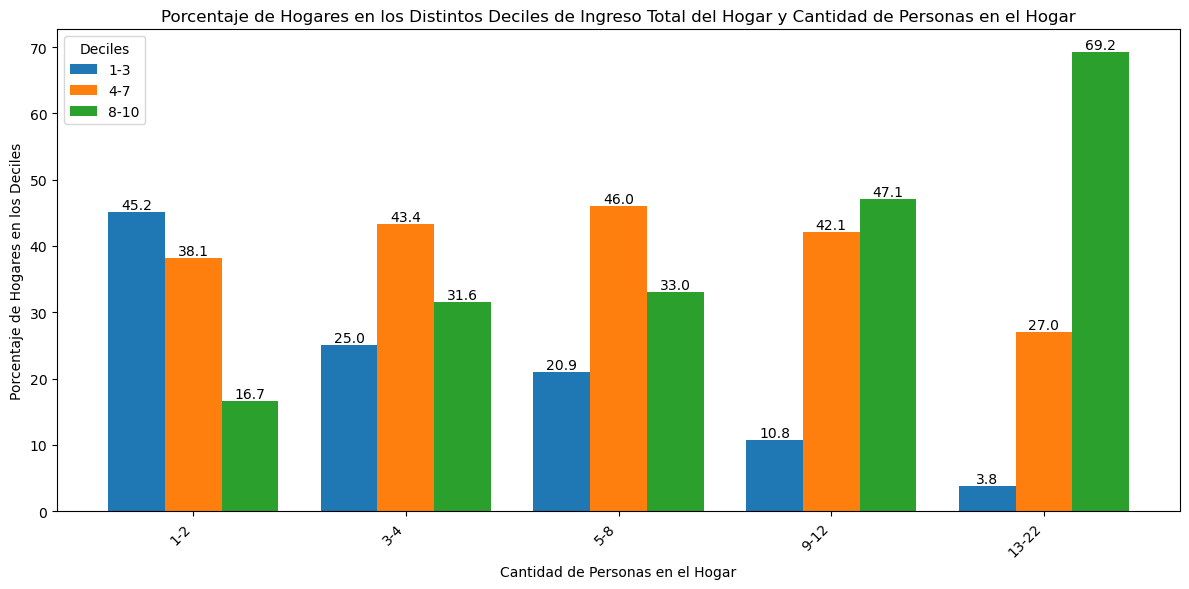

In [22]:
# Plotting
plot_title = ('Porcentaje de Hogares en los Distintos Deciles de Ingreso' + 
              ' Total del Hogar y Cantidad de Personas en el Hogar')
ylabel = 'Porcentaje de Hogares en los Deciles'
plot_people_deciles(DECIFR_gb, 'DECIFR', plot_title, ylabel)

In [23]:
# Removing unnecessary data
DECCFR_hogar = hogar.loc[hogar['DECCFR'] != 0,
                         ['people_group', 'DECCFR_group', 'CODUSU']]

# Grouping the data
DECCFR_gb = DECCFR_hogar.groupby(['people_group', 'DECCFR_group']).count()
DECCFR_gb

CODUSU
people_group DECCFR_group        
1-2          1-3            28028
             4-7            89806
             8-10           85291
13-22        1-3              318
             4-7               22
             8-10               1
3-4          1-3            63429
             4-7            69090
             8-10           27673
5-8          1-3            48973
             4-7            21494
             8-10            3298
9-12         1-3             3659
             4-7              478
             8-10              14

In [24]:
# Calculating the % column
# This calculates n for every people_group
group_sums = DECCFR_gb.groupby(level='people_group')['CODUSU'].sum()

# This calculates the percentages for every people_group
DECCFR_gb['%'] = (DECCFR_gb['CODUSU'] / DECCFR_gb.groupby(level='people_group')
                  ['CODUSU'].transform('sum') * 100)

DECCFR_gb = DECCFR_gb.drop(columns=['CODUSU'])
DECCFR_gb

%
people_group DECCFR_group           
1-2          1-3           13.798400
             4-7           44.212185
             8-10          41.989415
13-22        1-3           93.255132
             4-7            6.451613
             8-10           0.293255
3-4          1-3           39.595610
             4-7           43.129495
             8-10          17.274895
5-8          1-3           66.390565
             4-7           29.138480
             8-10           4.470955
9-12         1-3           88.147434
             4-7           11.515298
             8-10           0.337268

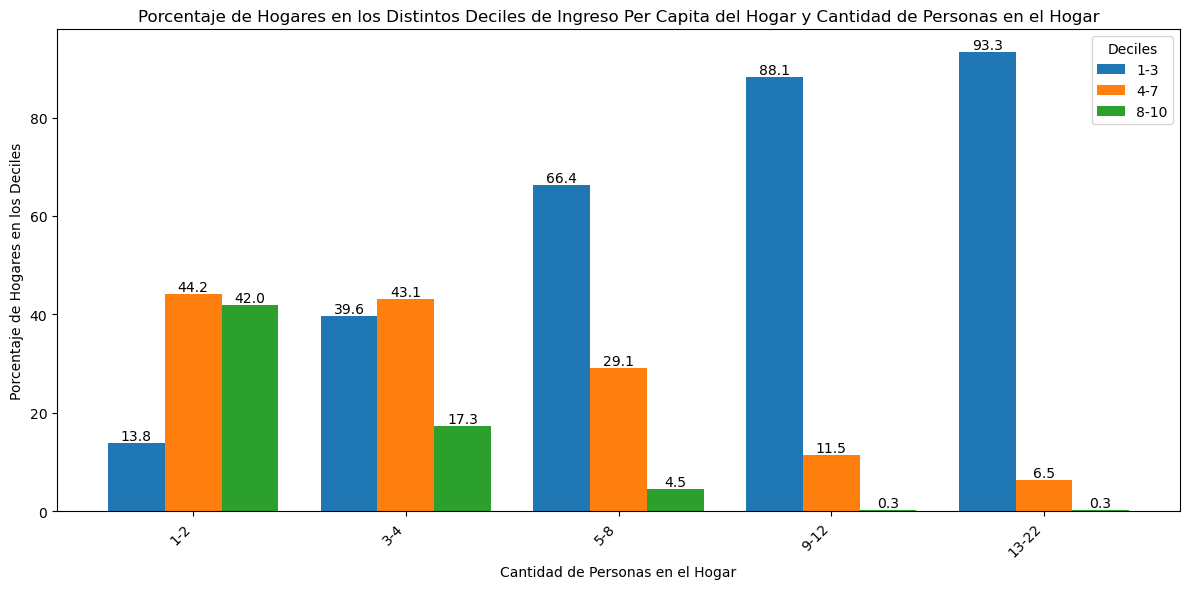

In [25]:
plot_title = ('Porcentaje de Hogares en los Distintos Deciles de Ingreso' + 
              ' Per Capita del Hogar y Cantidad de Personas en el Hogar')
y_label = 'Porcentaje de Hogares en los Deciles'
plot_people_deciles(DECCFR_gb, 'DECCFR', plot_title, ylabel)

In [26]:
hogar_reduced = hogar[['CODUSU', 'NRO_HOGAR', 'quarter', 'IX_TOT']].copy()
merged_data = hogar_reduced.merge(individual, how='inner',
                                  on=['quarter', 'CODUSU', 'NRO_HOGAR'])
merged_data

,CODUSU,NRO_HOGAR,quarter,IX_TOT,DECINDR
0,TQRMNOQUXHKOKMCDEGKDB00475140,1,2016Q2,4,9
1,TQRMNOQUXHKOKMCDEGKDB00475140,1,2016Q2,4,0
2,TQRMNOQUXHKOKMCDEGKDB00475140,1,2016Q2,4,0
3,TQRMNOQUXHKOKMCDEGKDB00475140,1,2016Q2,4,12
4,TQRMNOQQYHMMKTCDEGKDB00475009,1,2016Q2,3,8
...,...,...,...,...,...
1681656,TQRMNOSYXHMMLNCDEFNFF00798999,1,2024Q1,6,0
1681657,TQRMNOSYXHMMLNCDEFNFF00798999,1,2024Q1,6,0
1681658,TQRMNOPTSHLOLQCDEFNFF00852331,1,2024Q1,1,5
1681659,TQRMNOVRSHKOKMCDEFOCD00861772,1,2024Q1,2,5


In [27]:
# This part fixes the "DECINDR" column.
# Fixing a few strings
merged_data['DECINDR'] = merged_data['DECINDR'].apply(remove_first_zeros)

# Removing any NaNs
merged_data['DECINDR'] = merged_data['DECINDR'].fillna(0)

# Removing any invalid data
bool_mask = ((merged_data['DECINDR'] == 12) | (merged_data['DECINDR'] == '12') |
             (merged_data['DECINDR'] == 13) | (merged_data['DECINDR'] == '13') |
             (merged_data['DECINDR'] == '00') |
             (merged_data['DECINDR'] == '  '))
merged_data.loc[bool_mask, 'DECINDR'] = 0

merged_data['DECINDR'] = merged_data['DECINDR'].astype('int16')
display(merged_data.dtypes)
merged_data

CODUSU              object
NRO_HOGAR            int16
quarter      period[Q-DEC]
IX_TOT               int16
DECINDR              int16
dtype: object

,CODUSU,NRO_HOGAR,quarter,IX_TOT,DECINDR
0,TQRMNOQUXHKOKMCDEGKDB00475140,1,2016Q2,4,9
1,TQRMNOQUXHKOKMCDEGKDB00475140,1,2016Q2,4,0
2,TQRMNOQUXHKOKMCDEGKDB00475140,1,2016Q2,4,0
3,TQRMNOQUXHKOKMCDEGKDB00475140,1,2016Q2,4,0
4,TQRMNOQQYHMMKTCDEGKDB00475009,1,2016Q2,3,8
...,...,...,...,...,...
1681656,TQRMNOSYXHMMLNCDEFNFF00798999,1,2024Q1,6,0
1681657,TQRMNOSYXHMMLNCDEFNFF00798999,1,2024Q1,6,0
1681658,TQRMNOPTSHLOLQCDEFNFF00852331,1,2024Q1,1,5
1681659,TQRMNOVRSHKOKMCDEFOCD00861772,1,2024Q1,2,5


In [28]:
# This part creates the groups of IX_TOT
people_groups = ((0, 2), (2, 4), (4, 8), (8, 12), (12, 22))
merged_data['people_group'] = ''

for tupl in people_groups:
    bool_mask = ((merged_data['IX_TOT'] > tupl[0]) &
                 (merged_data['IX_TOT'] <= tupl[1]))
    merged_data.loc[bool_mask, 'people_group'] = f'{tupl[0]+1}-{tupl[1]}'

# This part creates the groups of "DECINDR"
decile_groups = ((0, 3), (3, 7), (7, 10))
merged_data['DECINDR_group'] = ''

for tupl in decile_groups:
    # Grouping DECINDR
    bool_mask = ((merged_data['DECINDR'] > tupl[0]) &
                 (merged_data['DECINDR'] <= tupl[1]))
    merged_data.loc[bool_mask, 'DECINDR_group'] = f'{tupl[0]+1}-{tupl[1]}'

# This removes unnecessary data
merged_data = merged_data.loc[merged_data['DECINDR'] != 0,
                              ['people_group', 'DECINDR_group', 'CODUSU']]
merged_data

,people_group,DECINDR_group,CODUSU
0,3-4,8-10,TQRMNOQUXHKOKMCDEGKDB00475140
4,3-4,8-10,TQRMNOQQYHMMKTCDEGKDB00475009
5,3-4,4-7,TQRMNOQQYHMMKTCDEGKDB00475009
7,1-2,4-7,TQRMNORVUHJMKSCDEGKDB00475326
8,1-2,4-7,TQRMNORVUHJMKSCDEGKDB00475326
...,...,...,...
1681652,5-8,1-3,TQRMNOSYXHMMLNCDEFNFF00798999
1681653,5-8,4-7,TQRMNOSYXHMMLNCDEFNFF00798999
1681654,5-8,1-3,TQRMNOSYXHMMLNCDEFNFF00798999
1681658,1-2,4-7,TQRMNOPTSHLOLQCDEFNFF00852331


In [29]:
# Grouping the data
merged_gb = merged_data.groupby(['people_group', 'DECINDR_group']).count()

# This calculates n for every people_group
group_sums = merged_gb.groupby(level='people_group')['CODUSU'].sum()

# This calculates the percentages for every people_group
merged_gb['%'] = (merged_gb['CODUSU'] / merged_gb.groupby(level='people_group')
                  ['CODUSU'].transform('sum') * 100)

merged_gb = merged_gb.drop(columns=['CODUSU'])
merged_gb

%
people_group DECINDR_group           
1-2          1-3            25.553936
             4-7            45.069017
             8-10           29.377047
13-22        1-3            59.755565
             4-7            34.788302
             8-10            5.456133
3-4          1-3            31.174773
             4-7            40.237946
             8-10           28.587281
5-8          1-3            42.130972
             4-7            39.402043
             8-10           18.466985
9-12         1-3            55.727277
             4-7            36.495552
             8-10            7.777170

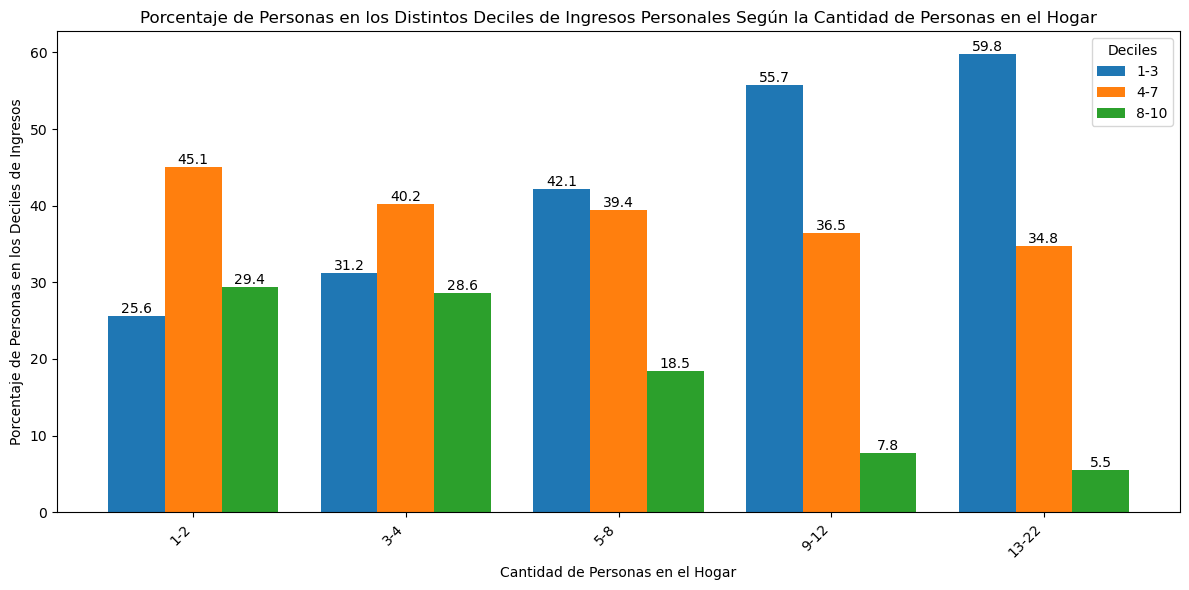

In [30]:
plot_title = ('Porcentaje de Personas en los Distintos Deciles de Ingresos' + 
              ' Personales Según la Cantidad de Personas en el Hogar')
ylabel = 'Porcentaje de Personas en los Deciles de Ingresos'
plot_people_deciles(merged_gb, 'DECINDR', plot_title, ylabel)